# Ноутбук 3: Retrieval на масштабе - точный поиск vs ANN (HNSW/FAISS)

**Цель:** Построить быстрый поиск ближайших соседей по эмбеддингам и оценить точность/латентность.

**Что делаем:**
1. Загрузка эмбеддингов из baseline или metric learning ноутбука (лучшая модель)
2. Точный поиск (baseline) с sklearn NearestNeighbors
3. Приближенный поиск с HNSW (hnswlib)
4. Приближенный поиск с FAISS (опционально)
5. Переранжирование (2-этапный поиск)
6. Сравнение методов и выводы


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# ANN libraries
try:
    import hnswlib
    HAS_HNSWLIB = True
except ImportError:
    HAS_HNSWLIB = False
    print("Warning: hnswlib not installed. Install with: pip install hnswlib")
except Exception as e:
    HAS_HNSWLIB = False
    print(f"Warning: hnswlib import failed: {e}")

try:
    import faiss
    HAS_FAISS = True
except ImportError:
    HAS_FAISS = False
    print("Warning: faiss not installed. Install with: pip install faiss-cpu or faiss-gpu")
except Exception as e:
    HAS_FAISS = False
    print(f"Warning: faiss import failed (possibly numpy version conflict): {e}")
    print("  Try: pip install --upgrade numpy")
    print("  Or: pip uninstall faiss-cpu faiss-gpu && pip install faiss-cpu")

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


Using device: cuda
GPU: NVIDIA L40
GPU memory: 44.38 GB


## 1. Загрузка эмбеддингов из лучшей модели

Загружаем модель из metric learning ноутбука (лучшая модель - combined или supcon) и извлекаем эмбеддинги для train, val и test наборов.


In [2]:
# Загрузка данных из baseline
checkpoint_dir = Path("./checkpoints/baseline")
data_dir = checkpoint_dir / "data"

X_train = np.load(data_dir / "X_train_scaled.npy")
X_val = np.load(data_dir / "X_val_scaled.npy")
X_test = np.load(data_dir / "X_test_scaled.npy")
y_train = np.load(data_dir / "y_train.npy")
y_val = np.load(data_dir / "y_val.npy")
y_test = np.load(data_dir / "y_test.npy")

print(f"Данные загружены:")
print(f"  Train: {len(X_train):,}")
print(f"  Val: {len(X_val):,}")
print(f"  Test: {len(X_test):,}")
print(f"  Input dim: {X_train.shape[1]}")


Данные загружены:
  Train: 628,138
  Val: 69,794
  Test: 116,323
  Input dim: 784


In [3]:
# Загрузка лучшей модели из metric learning
metric_dir = Path("./checkpoints/metric_learning")

# Пробуем загрузить combined модель (обычно лучшая)
model_path = metric_dir / "combined_model.pt"
if not model_path.exists():
    model_path = metric_dir / "supcon_model.pt"
    
if not model_path.exists():
    raise FileNotFoundError("Модель не найдена. Запустите сначала ноутбук 02_metric_learning.ipynb")

checkpoint = torch.load(model_path, map_location='cpu')
model_config = checkpoint['model_config']

print(f"Модель загружена: {model_path.name}")
print(f"  Embedding dim: {model_config['embedding_dim']}")
print(f"  Input dim: {model_config['input_dim']}")
print(f"  Classes: {model_config['n_classes']}")


Модель загружена: combined_model.pt
  Embedding dim: 128
  Input dim: 784
  Classes: 62


In [4]:
# Определение архитектуры модели
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout=0.3, embedding_dim=128):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, embedding_dim))
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x, normalize=True):
        embeddings = self.encoder(x)
        if normalize:
            embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, projection_dim),
            nn.BatchNorm1d(projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )
    
    def forward(self, embeddings, normalize=True):
        projections = self.projection(embeddings)
        if normalize:
            projections = F.normalize(projections, p=2, dim=1)
        return projections

class ClassificationHead(nn.Module):
    def __init__(self, embedding_dim, n_classes):
        super().__init__()
        self.classifier = nn.Linear(embedding_dim, n_classes)
    
    def forward(self, embeddings):
        return self.classifier(embeddings)

class MetricLearningModel(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dims=[512, 256, 128],
                 dropout=0.3, embedding_dim=128, projection_dim=128):
        super().__init__()
        self.encoder = MLPEncoder(input_dim, hidden_dims, dropout, embedding_dim)
        self.projector = ProjectionHead(embedding_dim, projection_dim)
        self.classifier = ClassificationHead(embedding_dim, n_classes)
    
    def forward(self, x, return_projection=False, return_embeddings=False):
        embeddings = self.encoder(x, normalize=True)
        projection = self.projector(embeddings, normalize=True)
        logits = self.classifier(embeddings)
        
        result = {'logits': logits}
        if return_projection:
            result['projection'] = projection
        if return_embeddings:
            result['embeddings'] = embeddings
        return result
    
    def get_embeddings(self, x):
        with torch.no_grad():
            embeddings = self.encoder(x, normalize=True)
        return embeddings

# Создание и загрузка модели
model = MetricLearningModel(**model_config).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Модель инициализирована и загружена")


Модель инициализирована и загружена


In [5]:
# Извлечение эмбеддингов
def extract_embeddings(model, X, batch_size=1024, device=device):
    """Извлекает эмбеддинги для всего датасета"""
    model.eval()
    all_embeddings = []
    
    dataset = TensorDataset(torch.FloatTensor(X))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    with torch.no_grad():
        for (X_batch,) in tqdm(dataloader, desc="Extracting embeddings"):
            X_batch = X_batch.to(device)
            embeddings = model.get_embeddings(X_batch)
            all_embeddings.append(embeddings.cpu().numpy())
    
    return np.concatenate(all_embeddings, axis=0)

print("Извлечение эмбеддингов для train...")
train_embeddings = extract_embeddings(model, X_train)
print(f"  Train embeddings shape: {train_embeddings.shape}")

print("Извлечение эмбеддингов для val...")
val_embeddings_full = extract_embeddings(model, X_val)
print(f"  Val embeddings shape: {val_embeddings_full.shape}")

print("Извлечение эмбеддингов для test...")
test_embeddings_full = extract_embeddings(model, X_test)
print(f"  Test embeddings shape: {test_embeddings_full.shape}")

# Семплирование для ускорения поиска
# Train: используем весь (без семплирования)
# Val и Test: берем по 1000 примеров

val_sample_size = min(1000, len(val_embeddings_full))
test_sample_size = min(1000, len(test_embeddings_full))

np.random.seed(42)
val_indices = np.random.choice(len(val_embeddings_full), size=val_sample_size, replace=False)
test_indices = np.random.choice(len(test_embeddings_full), size=test_sample_size, replace=False)

val_embeddings = val_embeddings_full[val_indices]
y_val_sampled = y_val[val_indices]

test_embeddings = test_embeddings_full[test_indices]
y_test_sampled = y_test[test_indices]

print(f"\nСемплирование для ускорения поиска:")
print(f"  Train: {len(train_embeddings):,} (весь датасет)")
print(f"  Val: {len(val_embeddings):,} из {len(val_embeddings_full):,} ({100*len(val_embeddings)/len(val_embeddings_full):.1f}%)")
print(f"  Test: {len(test_embeddings):,} из {len(test_embeddings_full):,} ({100*len(test_embeddings)/len(test_embeddings_full):.1f}%)")

embedding_dim = train_embeddings.shape[1]
print(f"\nEmbedding dimension: {embedding_dim}")

Извлечение эмбеддингов для train...


Extracting embeddings: 100%|██████████| 614/614 [00:02<00:00, 212.51it/s]


  Train embeddings shape: (628138, 128)
Извлечение эмбеддингов для val...


Extracting embeddings: 100%|██████████| 69/69 [00:00<00:00, 145.35it/s]


  Val embeddings shape: (69794, 128)
Извлечение эмбеддингов для test...


Extracting embeddings: 100%|██████████| 114/114 [00:00<00:00, 181.69it/s]

  Test embeddings shape: (116323, 128)

Семплирование для ускорения поиска:
  Train: 628,138 (весь датасет)
  Val: 1,000 из 69,794 (1.4%)
  Test: 1,000 из 116,323 (0.9%)

Embedding dimension: 128


## 2. Точный поиск (baseline)

Используем sklearn NearestNeighbors с brute-force алгоритмом и косинусной метрикой. Это будет эталон для сравнения точности и скорости.


In [7]:
def compute_recall_at_k(true_labels, retrieved_indices, retrieved_labels, k_values=[5, 10, 20]):
    """Вычисляет Recall@k для разных значений k"""
    recalls = {}
    for k in k_values:
        correct = 0
        total = len(true_labels)
        for i, true_label in enumerate(true_labels):
            # Берем top-k соседей
            top_k_labels = retrieved_labels[i][:k]
            if true_label in top_k_labels:
                correct += 1
        recalls[k] = correct / total
    return recalls

def evaluate_exact_search(train_emb, train_labels, query_emb, query_labels, k_values=[5, 10, 20]):
    """Оценивает точный поиск с sklearn NearestNeighbors"""
    print("Построение индекса точного поиска...")
    start_time = time.time()
    
    nn_model = NearestNeighbors(n_neighbors=max(k_values), metric='cosine', algorithm='brute', n_jobs=-1)
    nn_model.fit(train_emb)
    
    build_time = time.time() - start_time
    print(f"  Время построения индекса: {build_time:.4f} сек")
    
    # Оценка памяти (приблизительно)
    index_size_mb = (train_emb.nbytes) / (1024 ** 2)
    print(f"  Размер индекса: {index_size_mb:.2f} MB")
    
    print("Поиск ближайших соседей...")
    start_time = time.time()
    
    distances, indices = nn_model.kneighbors(query_emb)
    
    search_time = time.time() - start_time
    avg_latency = search_time / len(query_emb) * 1000  # мс на запрос
    throughput = len(query_emb) / search_time  # запросов в секунду
    
    print(f"  Время поиска: {search_time:.4f} сек")
    print(f"  Средняя латентность: {avg_latency:.4f} мс/запрос")
    print(f"  Throughput: {throughput:.2f} запросов/сек")
    
    # Вычисление Recall@k
    retrieved_labels = train_labels[indices]
    recalls = compute_recall_at_k(query_labels, indices, retrieved_labels, k_values)
    
    print("\nRecall@k:")
    for k, recall in recalls.items():
        print(f"  Recall@{k}: {recall:.4f}")
    
    return {
        'build_time': build_time,
        'search_time': search_time,
        'avg_latency': avg_latency,
        'throughput': throughput,
        'index_size_mb': index_size_mb,
        'recalls': recalls,
        'indices': indices,
        'distances': distances
    }

print("=" * 60)
print("ТОЧНЫЙ ПОИСК (Baseline)")
print("=" * 60)

exact_val_results = evaluate_exact_search(
    train_embeddings, y_train,
    val_embeddings, y_val_sampled,
    k_values=[5, 10, 20]
)

print("\n" + "=" * 60)
exact_test_results = evaluate_exact_search(
    train_embeddings, y_train,
    test_embeddings, y_test_sampled,
    k_values=[5, 10, 20]
)


ТОЧНЫЙ ПОИСК (Baseline)
Построение индекса точного поиска...
  Время построения индекса: 0.0259 сек
  Размер индекса: 306.71 MB
Поиск ближайших соседей...
  Время поиска: 8.5441 сек
  Средняя латентность: 8.5441 мс/запрос
  Throughput: 117.04 запросов/сек

Recall@k:
  Recall@5: 0.8870
  Recall@10: 0.9330
  Recall@20: 0.9560

Построение индекса точного поиска...
  Время построения индекса: 0.0311 сек
  Размер индекса: 306.71 MB
Поиск ближайших соседей...
  Время поиска: 8.2777 сек
  Средняя латентность: 8.2777 мс/запрос
  Throughput: 120.81 запросов/сек

Recall@k:
  Recall@5: 0.8790
  Recall@10: 0.9180
  Recall@20: 0.9510


In [8]:
if not HAS_HNSWLIB:
    print("hnswlib не установлен. Пропускаем HNSW эксперименты.")
else:
    def evaluate_hnsw(train_emb, train_labels, query_emb, query_labels, 
                      M=16, ef_construction=200, ef_search_values=[50, 100, 200, 400],
                      k_values=[5, 10, 20]):
        """Оценивает HNSW индекс"""
        print(f"\nHNSW параметры: M={M}, efConstruction={ef_construction}")
        
        # Построение индекса
        print("Построение HNSW индекса...")
        start_time = time.time()
        
        index = hnswlib.Index(space='cosine', dim=train_emb.shape[1])
        index.init_index(max_elements=len(train_emb), ef_construction=ef_construction, M=M)
        index.add_items(train_emb, np.arange(len(train_emb)))
        
        build_time = time.time() - start_time
        
        # Оценка памяти
        index_size_mb = index.get_current_count() * embedding_dim * 4 / (1024 ** 2)  # приблизительно
        print(f"  Время построения: {build_time:.4f} сек")
        print(f"  Размер индекса: {index_size_mb:.2f} MB")
        
        results = {}
        
        for ef_search in ef_search_values:
            print(f"\n  efSearch={ef_search}:")
            index.set_ef(ef_search)
            
            start_time = time.time()
            indices, distances = index.knn_query(query_emb, k=max(k_values))
            search_time = time.time() - start_time
            
            avg_latency = search_time / len(query_emb) * 1000
            throughput = len(query_emb) / search_time
            
            print(f"    Время поиска: {search_time:.4f} сек")
            print(f"    Средняя латентность: {avg_latency:.4f} мс/запрос")
            print(f"    Throughput: {throughput:.2f} запросов/сек")
            
            # Вычисление Recall@k
            retrieved_labels = train_labels[indices]
            recalls = compute_recall_at_k(query_labels, indices, retrieved_labels, k_values)
            
            print(f"    Recall@k:")
            for k, recall in recalls.items():
                print(f"      Recall@{k}: {recall:.4f}")
            
            results[ef_search] = {
                'build_time': build_time,
                'search_time': search_time,
                'avg_latency': avg_latency,
                'throughput': throughput,
                'index_size_mb': index_size_mb,
                'recalls': recalls,
                'indices': indices,
                'distances': distances
            }
        
        return results
    
    print("=" * 60)
    print("HNSW ПРИБЛИЖЕННЫЙ ПОИСК")
    print("=" * 60)
    
    # Эксперименты с разными параметрами
    hnsw_configs = [
        {'M': 16, 'ef_construction': 200},
        {'M': 32, 'ef_construction': 400},
    ]
    
    all_hnsw_results = {}
    
    for config in hnsw_configs:
        print(f"\n{'='*60}")
        print(f"Конфигурация: M={config['M']}, efConstruction={config['ef_construction']}")
        print(f"{'='*60}")
        
        hnsw_val_results = evaluate_hnsw(
            train_embeddings, y_train,
            val_embeddings, y_val_sampled,
            M=config['M'],
            ef_construction=config['ef_construction'],
            ef_search_values=[50, 100, 200, 400],
            k_values=[5, 10, 20]
        )
        
        config_key = f"M{config['M']}_efC{config['ef_construction']}"
        all_hnsw_results[config_key] = hnsw_val_results


HNSW ПРИБЛИЖЕННЫЙ ПОИСК

Конфигурация: M=16, efConstruction=200

HNSW параметры: M=16, efConstruction=200
Построение HNSW индекса...
  Время построения: 5.7244 сек
  Размер индекса: 306.71 MB

  efSearch=50:
    Время поиска: 0.0056 сек
    Средняя латентность: 0.0056 мс/запрос
    Throughput: 178336.83 запросов/сек
    Recall@k:
      Recall@5: 0.8860
      Recall@10: 0.9330
      Recall@20: 0.9530

  efSearch=100:
    Время поиска: 0.0078 сек
    Средняя латентность: 0.0078 мс/запрос
    Throughput: 128368.24 запросов/сек
    Recall@k:
      Recall@5: 0.8870
      Recall@10: 0.9330
      Recall@20: 0.9550

  efSearch=200:
    Время поиска: 0.0120 сек
    Средняя латентность: 0.0120 мс/запрос
    Throughput: 83108.19 запросов/сек
    Recall@k:
      Recall@5: 0.8870
      Recall@10: 0.9330
      Recall@20: 0.9550

  efSearch=400:
    Время поиска: 0.0208 сек
    Средняя латентность: 0.0208 мс/запрос
    Throughput: 48142.33 запросов/сек
    Recall@k:
      Recall@5: 0.8870
      Recal

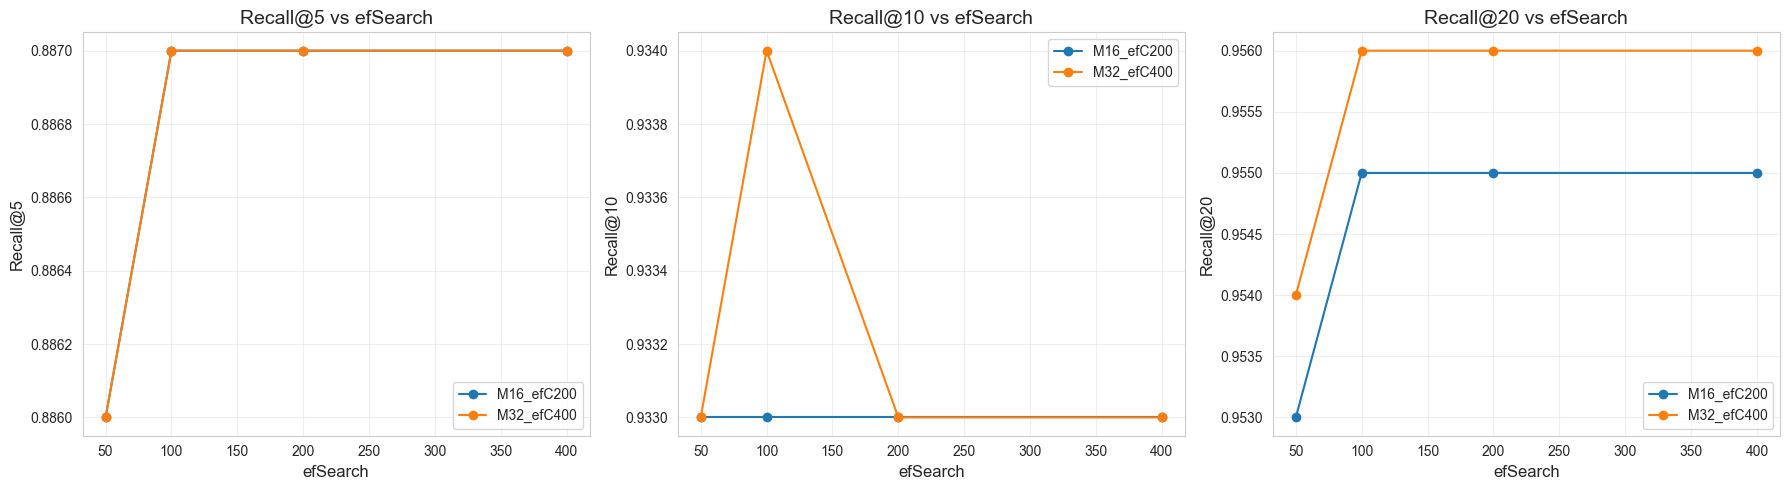

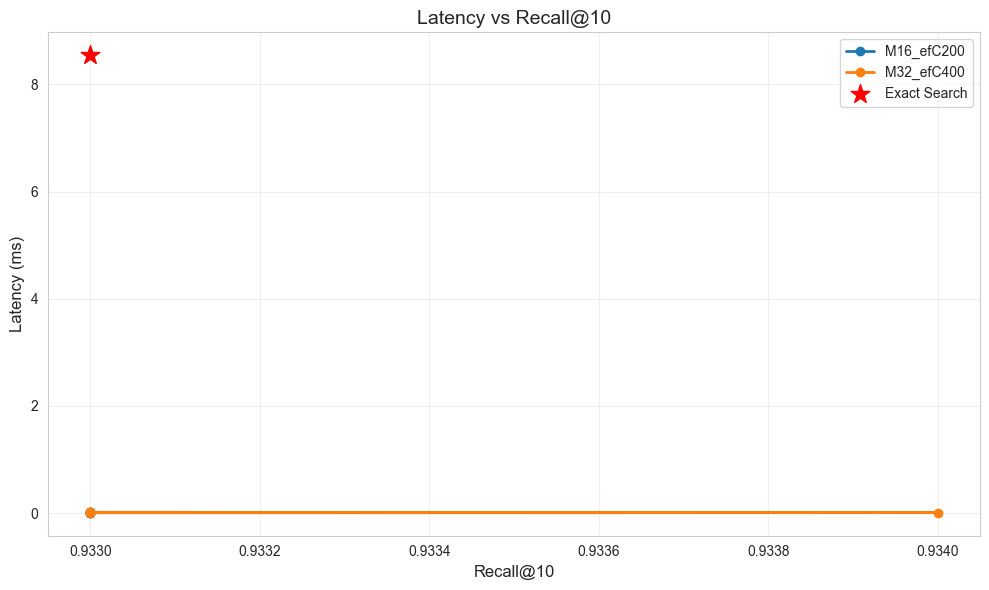

In [9]:
if HAS_HNSWLIB:
    # Визуализация зависимости Recall@k от efSearch
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    k_values_plot = [5, 10, 20]
    
    for idx, k in enumerate(k_values_plot):
        ax = axes[idx]
        for config_key, results in all_hnsw_results.items():
            ef_search_values = sorted(results.keys())
            recalls = [results[ef][f'recalls'][k] for ef in ef_search_values]
            ax.plot(ef_search_values, recalls, marker='o', label=config_key)
        
        ax.set_xlabel('efSearch', fontsize=12)
        ax.set_ylabel(f'Recall@{k}', fontsize=12)
        ax.set_title(f'Recall@{k} vs efSearch', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # График латентности vs Recall
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for config_key, results in all_hnsw_results.items():
        ef_search_values = sorted(results.keys())
        recalls_10 = [results[ef]['recalls'][10] for ef in ef_search_values]
        latencies = [results[ef]['avg_latency'] for ef in ef_search_values]
        ax.plot(recalls_10, latencies, marker='o', label=config_key, linewidth=2)
    
    # Добавляем точку точного поиска для сравнения
    ax.scatter([exact_val_results['recalls'][10]], [exact_val_results['avg_latency']], 
               color='red', s=200, marker='*', label='Exact Search', zorder=5)
    
    ax.set_xlabel('Recall@10', fontsize=12)
    ax.set_ylabel('Latency (ms)', fontsize=12)
    ax.set_title('Latency vs Recall@10', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## 4. Приближенный поиск с FAISS (опционально)

FAISS (Facebook AI Similarity Search) - библиотека для эффективного поиска похожих векторов. Рассмотрим два режима:
- **IVF-Flat**: Инвертированный файл с точным поиском внутри кластеров
- **IVF-PQ**: Инвертированный файл с Product Quantization для сжатия


In [10]:
if not HAS_FAISS:
    print("FAISS не установлен. Пропускаем FAISS эксперименты.")
else:
    def evaluate_faiss_ivf_flat(train_emb, train_labels, query_emb, query_labels,
                                nlist=100, nprobe_values=[1, 5, 10, 20, 50],
                                k_values=[5, 10, 20]):
        """Оценивает FAISS IVF-Flat индекс"""
        print(f"\nFAISS IVF-Flat: nlist={nlist}")
        
        # Нормализация для косинусной метрики
        faiss.normalize_L2(train_emb)
        faiss.normalize_L2(query_emb)
        
        # Построение индекса
        print("Построение FAISS IVF-Flat индекса...")
        start_time = time.time()
        
        quantizer = faiss.IndexFlatIP(embedding_dim)  # Inner Product для нормализованных векторов = cosine
        index = faiss.IndexIVFFlat(quantizer, embedding_dim, nlist)
        
        # Обучение на train данных
        index.train(train_emb)
        index.add(train_emb)
        
        build_time = time.time() - start_time
        
        # Оценка памяти
        index_size_mb = index.ntotal * embedding_dim * 4 / (1024 ** 2)  # приблизительно
        print(f"  Время построения: {build_time:.4f} сек")
        print(f"  Размер индекса: {index_size_mb:.2f} MB")
        
        results = {}
        
        for nprobe in nprobe_values:
            print(f"\n  nprobe={nprobe}:")
            index.nprobe = nprobe
            
            start_time = time.time()
            distances, indices = index.search(query_emb, max(k_values))
            search_time = time.time() - start_time
            
            avg_latency = search_time / len(query_emb) * 1000
            throughput = len(query_emb) / search_time
            
            print(f"    Время поиска: {search_time:.4f} сек")
            print(f"    Средняя латентность: {avg_latency:.4f} мс/запрос")
            print(f"    Throughput: {throughput:.2f} запросов/сек")
            
            # Вычисление Recall@k
            retrieved_labels = train_labels[indices]
            recalls = compute_recall_at_k(query_labels, indices, retrieved_labels, k_values)
            
            print(f"    Recall@k:")
            for k, recall in recalls.items():
                print(f"      Recall@{k}: {recall:.4f}")
            
            results[nprobe] = {
                'build_time': build_time,
                'search_time': search_time,
                'avg_latency': avg_latency,
                'throughput': throughput,
                'index_size_mb': index_size_mb,
                'recalls': recalls,
                'indices': indices,
                'distances': distances
            }
        
        return results
    
    def evaluate_faiss_ivf_pq(train_emb, train_labels, query_emb, query_labels,
                              nlist=100, m=8, nbits=8, nprobe_values=[1, 5, 10, 20, 50],
                              k_values=[5, 10, 20]):
        """Оценивает FAISS IVF-PQ индекс"""
        print(f"\nFAISS IVF-PQ: nlist={nlist}, m={m}, nbits={nbits}")
        
        # Нормализация
        faiss.normalize_L2(train_emb)
        faiss.normalize_L2(query_emb)
        
        # Построение индекса
        print("Построение FAISS IVF-PQ индекса...")
        start_time = time.time()
        
        quantizer = faiss.IndexFlatIP(embedding_dim)
        index = faiss.IndexIVFPQ(quantizer, embedding_dim, nlist, m, nbits)
        
        index.train(train_emb)
        index.add(train_emb)
        
        build_time = time.time() - start_time
        
        # Оценка памяти (PQ сжимает векторы)
        index_size_mb = index.ntotal * m * nbits / 8 / (1024 ** 2)  # приблизительно
        print(f"  Время построения: {build_time:.4f} сек")
        print(f"  Размер индекса: {index_size_mb:.2f} MB")
        
        results = {}
        
        for nprobe in nprobe_values:
            print(f"\n  nprobe={nprobe}:")
            index.nprobe = nprobe
            
            start_time = time.time()
            distances, indices = index.search(query_emb, max(k_values))
            search_time = time.time() - start_time
            
            avg_latency = search_time / len(query_emb) * 1000
            throughput = len(query_emb) / search_time
            
            print(f"    Время поиска: {search_time:.4f} сек")
            print(f"    Средняя латентность: {avg_latency:.4f} мс/запрос")
            print(f"    Throughput: {throughput:.2f} запросов/сек")
            
            # Вычисление Recall@k
            retrieved_labels = train_labels[indices]
            recalls = compute_recall_at_k(query_labels, indices, retrieved_labels, k_values)
            
            print(f"    Recall@k:")
            for k, recall in recalls.items():
                print(f"      Recall@{k}: {recall:.4f}")
            
            results[nprobe] = {
                'build_time': build_time,
                'search_time': search_time,
                'avg_latency': avg_latency,
                'throughput': throughput,
                'index_size_mb': index_size_mb,
                'recalls': recalls,
                'indices': indices,
                'distances': distances
            }
        
        return results
    
    print("=" * 60)
    print("FAISS ПРИБЛИЖЕННЫЙ ПОИСК")
    print("=" * 60)
    
    # IVF-Flat
    print("\n" + "="*60)
    print("IVF-Flat")
    print("="*60)
    faiss_ivf_flat_results = evaluate_faiss_ivf_flat(
        train_embeddings.copy(), y_train,
        val_embeddings.copy(), y_val_sampled,
        nlist=100,
        nprobe_values=[1, 5, 10, 20, 50],
        k_values=[5, 10, 20]
    )
    
    # IVF-PQ
    print("\n" + "="*60)
    print("IVF-PQ")
    print("="*60)
    faiss_ivf_pq_results = evaluate_faiss_ivf_pq(
        train_embeddings.copy(), y_train,
        val_embeddings.copy(), y_val_sampled,
        nlist=100, m=8, nbits=8,
        nprobe_values=[1, 5, 10, 20, 50],
        k_values=[5, 10, 20]
    )


FAISS ПРИБЛИЖЕННЫЙ ПОИСК

IVF-Flat

FAISS IVF-Flat: nlist=100
Построение FAISS IVF-Flat индекса...
  Время построения: 1.6215 сек
  Размер индекса: 306.71 MB

  nprobe=1:
    Время поиска: 0.0437 сек
    Средняя латентность: 0.0437 мс/запрос
    Throughput: 22896.92 запросов/сек
    Recall@k:
      Recall@5: 0.8730
      Recall@10: 0.9210
      Recall@20: 0.9410

  nprobe=5:
    Время поиска: 0.1355 сек
    Средняя латентность: 0.1355 мс/запрос
    Throughput: 7381.44 запросов/сек
    Recall@k:
      Recall@5: 0.8830
      Recall@10: 0.9290
      Recall@20: 0.9530

  nprobe=10:
    Время поиска: 0.2271 сек
    Средняя латентность: 0.2271 мс/запрос
    Throughput: 4404.19 запросов/сек
    Recall@k:
      Recall@5: 0.8850
      Recall@10: 0.9310
      Recall@20: 0.9550

  nprobe=20:
    Время поиска: 0.3660 сек
    Средняя латентность: 0.3660 мс/запрос
    Throughput: 2732.10 запросов/сек
    Recall@k:
      Recall@5: 0.8870
      Recall@10: 0.9330
      Recall@20: 0.9560

  nprobe=50:
 

In [11]:
def evaluate_reranking(ann_indices, ann_distances, train_emb, train_labels, 
                       query_emb, query_labels, rerank_k=50, final_k_values=[5, 10, 20]):
    """Переранжирование: точный поиск на top-k кандидатах от ANN"""
    print(f"\nПереранжирование top-{rerank_k} кандидатов...")
    
    start_time = time.time()
    
    # Берем top-rerank_k кандидатов от ANN
    top_candidates = ann_indices[:, :rerank_k]
    
    # Вычисляем точные косинусные расстояния для кандидатов
    reranked_indices = []
    reranked_distances = []
    
    for i, query_vec in enumerate(tqdm(query_emb, desc="Reranking")):
        candidate_indices = top_candidates[i]
        candidate_embeddings = train_emb[candidate_indices]
        
        # Косинусное расстояние
        cosine_sims = np.dot(candidate_embeddings, query_vec)
        cosine_distances = 1 - cosine_sims
        
        # Сортировка по расстоянию
        sorted_idx = np.argsort(cosine_distances)
        reranked_indices.append(candidate_indices[sorted_idx])
        reranked_distances.append(cosine_distances[sorted_idx])
    
    reranked_indices = np.array(reranked_indices)
    reranked_distances = np.array(reranked_distances)
    
    rerank_time = time.time() - start_time
    avg_latency = rerank_time / len(query_emb) * 1000
    
    print(f"  Время переранжирования: {rerank_time:.4f} сек")
    print(f"  Средняя латентность: {avg_latency:.4f} мс/запрос")
    
    # Вычисление Recall@k
    retrieved_labels = train_labels[reranked_indices]
    recalls = compute_recall_at_k(query_labels, reranked_indices, retrieved_labels, final_k_values)
    
    print(f"\n  Recall@k после переранжирования:")
    for k, recall in recalls.items():
        print(f"    Recall@{k}: {recall:.4f}")
    
    return {
        'rerank_time': rerank_time,
        'avg_latency': avg_latency,
        'recalls': recalls,
        'indices': reranked_indices,
        'distances': reranked_distances
    }

if HAS_HNSWLIB:
    print("=" * 60)
    print("ПЕРЕРАНЖИРОВАНИЕ (HNSW + точный поиск)")
    print("=" * 60)
    
    # Используем лучшую конфигурацию HNSW
    best_config_key = list(all_hnsw_results.keys())[0]
    best_ef_search = 200  # Выбираем средний efSearch
    
    print(f"\nИспользуем HNSW: {best_config_key}, efSearch={best_ef_search}")
    hnsw_results = all_hnsw_results[best_config_key][best_ef_search]
    
    rerank_results = evaluate_reranking(
        hnsw_results['indices'],
        hnsw_results['distances'],
        train_embeddings, y_train,
        val_embeddings, y_val_sampled,
        rerank_k=50,
        final_k_values=[5, 10, 20]
    )
    
    # Сравнение с оригинальным HNSW
    print("\n" + "-"*60)
    print("Сравнение HNSW vs HNSW + Reranking:")
    print("-"*60)
    print(f"HNSW только:")
    for k in [5, 10, 20]:
        print(f"  Recall@{k}: {hnsw_results['recalls'][k]:.4f}")
    print(f"\nHNSW + Reranking:")
    for k in [5, 10, 20]:
        print(f"  Recall@{k}: {rerank_results['recalls'][k]:.4f}")
    
    # Общая латентность (ANN + reranking)
    total_latency = hnsw_results['avg_latency'] + rerank_results['avg_latency']
    print(f"\nОбщая латентность: {total_latency:.4f} мс (ANN: {hnsw_results['avg_latency']:.4f} + Rerank: {rerank_results['avg_latency']:.4f})")
    print(f"Точный поиск латентность: {exact_val_results['avg_latency']:.4f} мс")


ПЕРЕРАНЖИРОВАНИЕ (HNSW + точный поиск)

Используем HNSW: M16_efC200, efSearch=200

Переранжирование top-50 кандидатов...


Reranking: 100%|██████████| 1000/1000 [00:00<00:00, 93314.59it/s]

  Время переранжирования: 0.0131 сек
  Средняя латентность: 0.0131 мс/запрос

  Recall@k после переранжирования:
    Recall@5: 0.8870
    Recall@10: 0.9330
    Recall@20: 0.9550

------------------------------------------------------------
Сравнение HNSW vs HNSW + Reranking:
------------------------------------------------------------
HNSW только:
  Recall@5: 0.8870
  Recall@10: 0.9330
  Recall@20: 0.9550

HNSW + Reranking:
  Recall@5: 0.8870
  Recall@10: 0.9330
  Recall@20: 0.9550

Общая латентность: 0.0251 мс (ANN: 0.0120 + Rerank: 0.0131)
Точный поиск латентность: 8.5441 мс


In [12]:
# Создание итоговой таблицы сравнения
comparison_data = []

# Точный поиск
comparison_data.append({
    'Method': 'Exact Search (sklearn)',
    'Recall@5': exact_val_results['recalls'][5],
    'Recall@10': exact_val_results['recalls'][10],
    'Recall@20': exact_val_results['recalls'][20],
    'Latency (ms)': exact_val_results['avg_latency'],
    'Throughput (qps)': exact_val_results['throughput'],
    'Index Size (MB)': exact_val_results['index_size_mb'],
    'Build Time (s)': exact_val_results['build_time']
})

# HNSW результаты
if HAS_HNSWLIB:
    for config_key, results in all_hnsw_results.items():
        for ef_search, result in results.items():
            comparison_data.append({
                'Method': f'HNSW ({config_key}, ef={ef_search})',
                'Recall@5': result['recalls'][5],
                'Recall@10': result['recalls'][10],
                'Recall@20': result['recalls'][20],
                'Latency (ms)': result['avg_latency'],
                'Throughput (qps)': result['throughput'],
                'Index Size (MB)': result['index_size_mb'],
                'Build Time (s)': result['build_time']
            })
    
    # Переранжирование
    if 'rerank_results' in locals():
        comparison_data.append({
            'Method': f'HNSW + Rerank (ef={best_ef_search})',
            'Recall@5': rerank_results['recalls'][5],
            'Recall@10': rerank_results['recalls'][10],
            'Recall@20': rerank_results['recalls'][20],
            'Latency (ms)': total_latency,
            'Throughput (qps)': len(val_embeddings) / (rerank_results['rerank_time'] + all_hnsw_results[best_config_key][best_ef_search]['search_time']),
            'Index Size (MB)': all_hnsw_results[best_config_key][best_ef_search]['index_size_mb'],
            'Build Time (s)': all_hnsw_results[best_config_key][best_ef_search]['build_time']
        })

# FAISS результаты
if HAS_FAISS:
    for nprobe, result in faiss_ivf_flat_results.items():
        comparison_data.append({
            'Method': f'FAISS IVF-Flat (nprobe={nprobe})',
            'Recall@5': result['recalls'][5],
            'Recall@10': result['recalls'][10],
            'Recall@20': result['recalls'][20],
            'Latency (ms)': result['avg_latency'],
            'Throughput (qps)': result['throughput'],
            'Index Size (MB)': result['index_size_mb'],
            'Build Time (s)': result['build_time']
        })
    
    for nprobe, result in faiss_ivf_pq_results.items():
        comparison_data.append({
            'Method': f'FAISS IVF-PQ (nprobe={nprobe})',
            'Recall@5': result['recalls'][5],
            'Recall@10': result['recalls'][10],
            'Recall@20': result['recalls'][20],
            'Latency (ms)': result['avg_latency'],
            'Throughput (qps)': result['throughput'],
            'Index Size (MB)': result['index_size_mb'],
            'Build Time (s)': result['build_time']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Recall@10', ascending=False)

print("=" * 100)
print("ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Сохранение результатов
save_dir = Path("./checkpoints/retrieval_ann")
save_dir.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(save_dir / "comparison_results.csv", index=False)

results_dict = {
    'exact_val': exact_val_results,
    'exact_test': exact_test_results,
}

if HAS_HNSWLIB:
    results_dict['hnsw'] = all_hnsw_results
    if 'rerank_results' in locals():
        results_dict['rerank'] = rerank_results

if HAS_FAISS:
    results_dict['faiss_ivf_flat'] = faiss_ivf_flat_results
    results_dict['faiss_ivf_pq'] = faiss_ivf_pq_results

with open(save_dir / "all_results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

print(f"\nРезультаты сохранены в {save_dir}")


ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ
                    Method  Recall@5  Recall@10  Recall@20  Latency (ms)  Throughput (qps)  Index Size (MB)  Build Time (s)
 HNSW (M32_efC400, ef=100)     0.887      0.934      0.956      0.009468     105623.369428       306.708008       11.421113
    Exact Search (sklearn)     0.887      0.933      0.956      8.544066        117.040298       306.708008        0.025883
 HNSW (M16_efC200, ef=100)     0.887      0.933      0.955      0.007790     128368.243864       306.708008        5.724436
  HNSW (M16_efC200, ef=50)     0.886      0.933      0.953      0.005607     178336.834049       306.708008        5.724436
 HNSW (M16_efC200, ef=200)     0.887      0.933      0.955      0.012033      83108.187366       306.708008        5.724436
 HNSW (M16_efC200, ef=400)     0.887      0.933      0.955      0.020772      48142.327514       306.708008        5.724436
  HNSW (M32_efC400, ef=50)     0.886      0.933      0.954      0.006929     144317.654750       306.7080

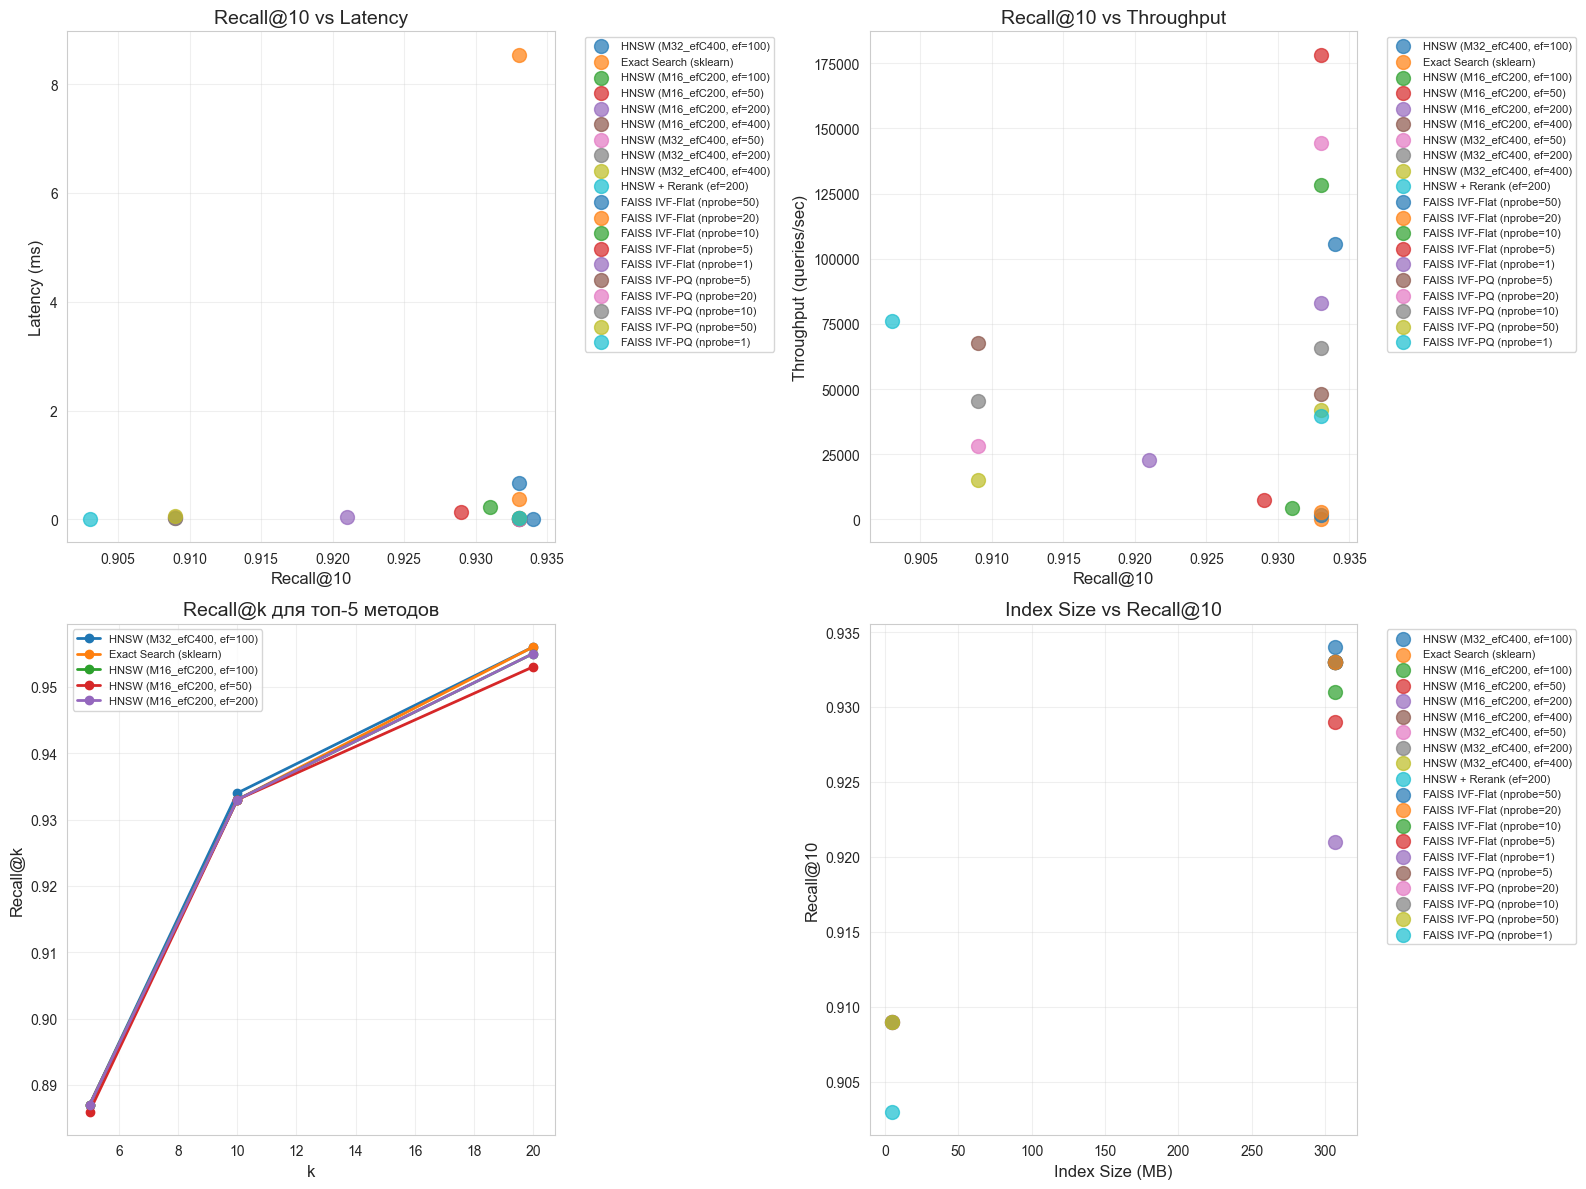

In [13]:
# Визуализация сравнения методов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recall@10 vs Latency
ax = axes[0, 0]
for _, row in comparison_df.iterrows():
    ax.scatter(row['Recall@10'], row['Latency (ms)'], s=100, alpha=0.7, label=row['Method'])
ax.set_xlabel('Recall@10', fontsize=12)
ax.set_ylabel('Latency (ms)', fontsize=12)
ax.set_title('Recall@10 vs Latency', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# 2. Recall@10 vs Throughput
ax = axes[0, 1]
for _, row in comparison_df.iterrows():
    ax.scatter(row['Recall@10'], row['Throughput (qps)'], s=100, alpha=0.7, label=row['Method'])
ax.set_xlabel('Recall@10', fontsize=12)
ax.set_ylabel('Throughput (queries/sec)', fontsize=12)
ax.set_title('Recall@10 vs Throughput', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# 3. Recall@k для разных методов (топ-5 методов)
ax = axes[1, 0]
top_methods = comparison_df.head(5)['Method'].values
for method in top_methods:
    method_row = comparison_df[comparison_df['Method'] == method].iloc[0]
    ax.plot([5, 10, 20], 
            [method_row['Recall@5'], method_row['Recall@10'], method_row['Recall@20']],
            marker='o', label=method, linewidth=2)
ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Recall@k', fontsize=12)
ax.set_title('Recall@k для топ-5 методов', fontsize=14)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 4. Index Size vs Recall@10
ax = axes[1, 1]
for _, row in comparison_df.iterrows():
    ax.scatter(row['Index Size (MB)'], row['Recall@10'], s=100, alpha=0.7, label=row['Method'])
ax.set_xlabel('Index Size (MB)', fontsize=12)
ax.set_ylabel('Recall@10', fontsize=12)
ax.set_title('Index Size vs Recall@10', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_dir / "comparison_plots.png", dpi=150, bbox_inches='tight')
plt.show()
